# Modeling
Big notebook, lots of stuff.  I'm going to try to break it up into sections.

## Environment and Custom Functions

In [575]:
import os
import numpy as np
import pandas as pd
import pyarrow as pa
import fastparquet as fp

In [576]:
def print_shape(df):
    print(f"Rows: {df.shape[0]:,} \nColumns: {df.shape[1]:,}")

In [577]:
def keep_latest(df, dedupe_by_cols, sort_by_cols):
    """Keep last record for each unique combination of dupe_cols, ordering by sort_cols"""
    df = df.sort_values(sort_by_cols).drop_duplicates(dedupe_by_cols, keep="last")
    return df

In [578]:
# calculate percent missing for each field in df
def percent_missing(df):
    # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )
    # Print some summary information
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )
    # Return the dataframe with missing information
    return mis_val_table_ren_columns


In [579]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def test_results(y_test, y_pred):
    print("R2: ", round(r2_score(y_test, y_pred),3))
    print("MAE: ", round(mean_absolute_error(y_test, y_pred),2))
    print("MAPE: ", round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,1),"%")
    print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
    print("Percent Underpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) >= 0]) / len(y_test) * 100,1),"%")
    print("Mean of Underpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) > 0]),2))
    print("Percent Overpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) < 0]) / len(y_test) * 100,1),"%")
    print("Mean of Overpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) < 0]),2))
    print("Mean Error: ", round(np.mean(y_test - y_pred),2)) 
    

## Load Data

In [580]:
standard_features_file = "/Users/shea/Downloads/sync_exclude/large_sample-standard_features.parquet"
df = fp.ParquetFile(standard_features_file).to_pandas()
df["engine_size"] = df["engine_size"].astype("float")
print_shape(df)


Rows: 1,858,778 
Columns: 31


In [581]:
df.columns

Index(['vin', 'status_date', 'price', 'miles', 'year', 'make', 'model', 'trim',
       'vehicle_type', 'body_type', 'drivetrain', 'fuel_type', 'engine_block',
       'engine_size', 'transmission', 'doors', 'cylinders', 'city_mpg',
       'highway_mpg', 'base_exterior_color', 'base_interior_color',
       'is_certified', 'state', 'zip', 'latitude', 'longitude', 'dealer_type',
       'photo_links_count', 'photo_main', 'mvr_purchase_date', 'mvr_price'],
      dtype='object')

In [582]:
hvf_options_file = "/Users/shea/Downloads/sync_exclude/hvf_options.parquet"
hvf_options = fp.ParquetFile(hvf_options_file).to_pandas()
print_shape(hvf_options)

Rows: 1,585,169 
Columns: 82


## Initial EDA

In [ ]:
# check for missing
percent_missing(df)

Your selected dataframe has 36 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
engine_block,52867,5.9
cylinders,52867,5.9
engine_size,52534,5.8
population_density,9146,1.0
median_income,9146,1.0
latitude,238,0.0
longitude,238,0.0
transmission,177,0.0
zip,26,0.0


In [ ]:
# pearson and spearman correlations between all features and target
df.select_dtypes(include=['number']).corrwith(df["mvr_price"]).sort_values(ascending=False)
df.corr(method="pearson")["target"].sort_values(ascending=False)
df.corr(method="spearman")["target"].sort_values(ascending=False)


mvr_price         AxesSubplot(0.125,0.53;0.168478x0.35)
miles          AxesSubplot(0.327174,0.53;0.168478x0.35)
age            AxesSubplot(0.529348,0.53;0.168478x0.35)
engine_size    AxesSubplot(0.731522,0.53;0.168478x0.35)
cylinders         AxesSubplot(0.125,0.11;0.168478x0.35)
doors          AxesSubplot(0.327174,0.11;0.168478x0.35)
photo_count    AxesSubplot(0.529348,0.11;0.168478x0.35)
mpg            AxesSubplot(0.731522,0.11;0.168478x0.35)
dtype: object

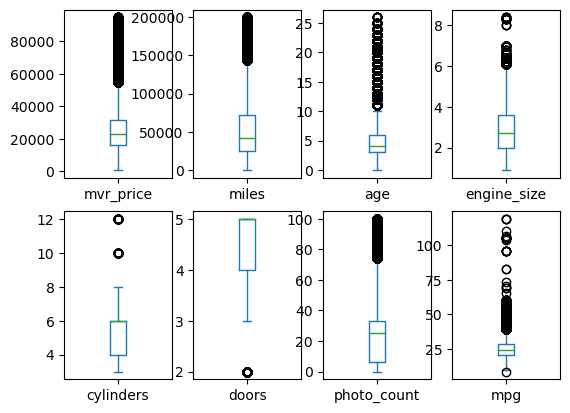

In [ ]:
# boxplots of numeric variables
df[["mvr_price","miles","age","engine_size","cylinders","doors","photo_count","mpg"]].plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False)

In [ ]:
df.groupby(["make"])["make"].count().sort_values()

make
Tesla                 1
KARMA                 1
Maybach               1
Lamborghini           2
Rolls-Royce           2
Ferrari               4
Lotus                 7
Bentley              10
Isuzu                11
Plymouth             12
Aston Martin         27
Oldsmobile           30
Saab                 38
Suzuki               79
Hummer              136
smart               162
Mercury             329
Saturn              366
Pontiac             598
Maserati            602
GENESIS             670
Alfa Romeo          801
Scion               902
FIAT               1003
Jaguar             1731
MINI               2272
Porsche            2333
Mitsubishi         3957
Volvo              4178
Land Rover         4744
Lincoln            8496
INFINITI           8986
Acura              9342
Audi              10949
Chrysler          11221
Buick             12068
Mazda             14052
Mercedes-Benz     14062
Subaru            15384
Cadillac          16264
Lexus             18172
Volkswagen 

In [ ]:
# increase pandas display rows
pd.set_option('display.max_rows', 1000)

# count by make and model
df.groupby(["make", "model"])["model"].count().sort_index()

make           model                             
Acura          CL                                        3
               ILX                                     831
               Integra                                   2
               MDX                                    3042
               NSX                                       1
               RDX                                    2751
               RL                                       20
               RLX                                     112
               RSX                                       9
               TL                                      509
               TLX                                    1831
               TSX                                     222
               ZDX                                       9
Alfa Romeo     4C                                        7
               Giulia                                  442
               Stelvio                                 352
Aston 

## Target Variable

In [583]:
# drop listing price var
# not using this because it's not available at time of listing
df.drop(columns=["price"], inplace=True)

In [584]:
# drop missing/0 price values
print_shape(df)
df = df[df["mvr_price"].notna()]
df = df[df["mvr_price"] > 1]
print_shape(df)

Rows: 1,858,778 
Columns: 30
Rows: 1,417,304 
Columns: 30


In [585]:
df["mvr_price"].describe()

count    1.417304e+06
mean     2.629080e+04
std      9.093204e+04
min      1.100000e+00
25%      1.552198e+04
50%      2.317900e+04
75%      3.323800e+04
max      1.000000e+08
Name: mvr_price, dtype: float64

In [586]:
# calculate high and low prices
top = df["mvr_price"].quantile(0.995)
print(top)
bottom = df["mvr_price"].quantile(0.005)
print(bottom)

94900.0
850.0


We're not sellin' Ferraris and Lamborghinis here. We're sellin' everyday used cars.

In [587]:
# keep mvr_price between top and bottom
print_shape(df)
df = df[df["mvr_price"] < top]
df = df[df["mvr_price"] > bottom]
print_shape(df)

Rows: 1,417,304 
Columns: 30
Rows: 1,403,090 
Columns: 30


<AxesSubplot:>

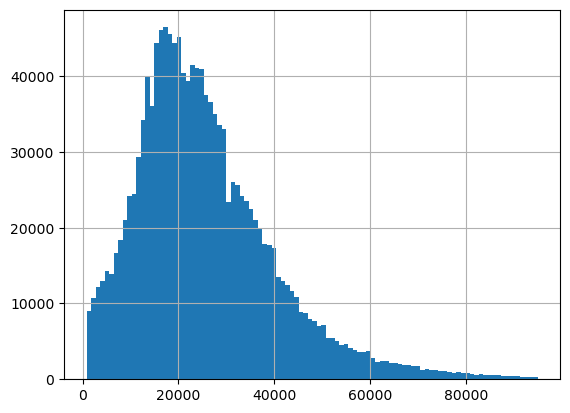

In [588]:
# plot distribution of mvr_price
df["mvr_price"].hist(bins=100)

In [ ]:
# box-cox transform mvr_price
from scipy import stats
df["mvr_price_bc"], bc_lambda = stats.boxcox(df["mvr_price"])
df["mvr_price_bc"].hist(bins=100)

In [590]:
df.drop(columns=["mvr_price_bc"], inplace=True)

## Feature Engineering

### Temporal

#### Vehicle Age

In [591]:
df["age"] = (df["mvr_purchase_date"].dt.year - df["year"] + 1)

<AxesSubplot:>

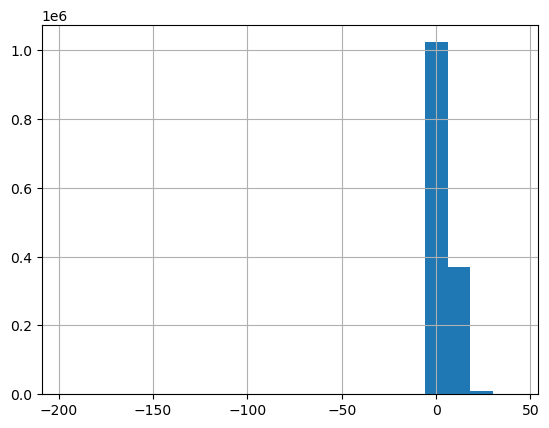

In [592]:
df["age"].hist(bins=20)

#### Month of Year

In [593]:
# purchase month
df["mvr_purchase_month"] = df["mvr_purchase_date"].dt.month.astype("category")

<AxesSubplot:>

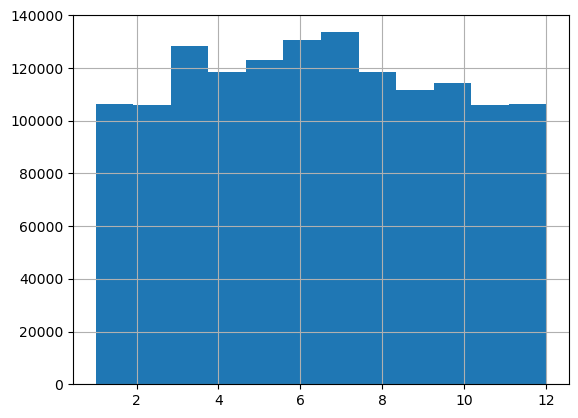

In [594]:
df["mvr_purchase_month"].hist(bins=12)

### Numeric

#### Miles

In [595]:
df["miles"].quantile(0.995)

219902.0499999998

In [596]:
print_shape(df)
df = df[df["miles"] < 200000]
print_shape(df)

Rows: 1,403,090 
Columns: 32
Rows: 1,368,068 
Columns: 32


<AxesSubplot:>

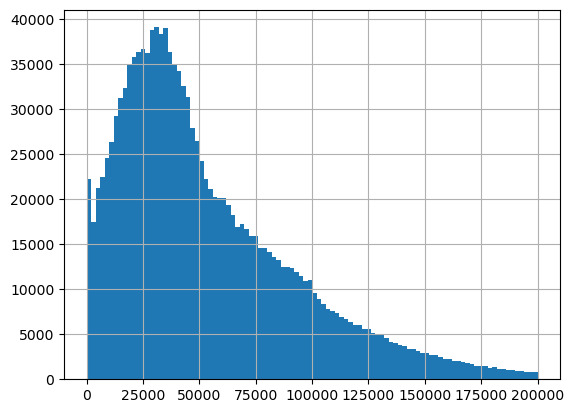

In [597]:
df["miles"].hist(bins=100)

#### Miles / Year

Capture the difference between a car that's driven a lot in a short period of time and a car that's driven a little in a long period of time, etc.

In [598]:
df["annual_mileage"] = df["miles"] / (df["age"] + 1)

In [599]:
df["annual_mileage"].describe()

count    1.366239e+06
mean              inf
std               NaN
min     -5.803600e+04
25%      5.178437e+03
50%      7.917778e+03
75%      1.111750e+04
max               inf
Name: annual_mileage, dtype: float64

#### Listing / Sale Date Difference

In [600]:
# difference between the last listing and the sale date recorded on the state registration
df["list_sale_diff"] = (df['mvr_purchase_date'] - df['status_date']).astype('timedelta64[D]')
print_shape(df)
# drop na's
df.dropna(subset=["list_sale_diff"], inplace=True)
print_shape(df)
# keep records with difference less than 90 days
df = df[abs(df["list_sale_diff"]) < 90]
print_shape(df)


Rows: 1,368,068 
Columns: 34
Rows: 1,368,065 
Columns: 34
Rows: 950,981 
Columns: 34


#### Fuel Economy

In [601]:
# epa weights city/highway 55/45
df["mpg"] = df["city_mpg"] * 0.55 + df["highway_mpg"] * 0.45
df.drop(columns=["city_mpg", "highway_mpg"], inplace=True)

In [602]:
# drop na's
print_shape(df)
df.dropna(subset=["mpg"], inplace=True)
print_shape(df)

Rows: 950,981 
Columns: 33
Rows: 898,218 
Columns: 33


#### Certified

In [603]:
df["is_certified"].fillna(0, inplace=True)

#### Photos

In [604]:
# rename photo_links_count to photo_count
df.rename(columns={"photo_links_count": "photo_count"}, inplace=True)

In [605]:
# cap at 100
df.loc[df["photo_count"] > 100, "photo_count"] = 100

In [606]:
df.drop(columns=["photo_main"], inplace=True)

### Categorical

#### Make

In [607]:
df["make"].value_counts()

Ford             125305
Chevrolet        121397
Toyota            85894
Nissan            67702
Honda             60746
Jeep              51126
GMC               38698
Kia               32489
Hyundai           31690
Dodge             30537
RAM               25649
BMW               24377
Volkswagen        19712
Lexus             19701
Mercedes-Benz     18195
Cadillac          17336
Subaru            16792
Mazda             14872
Buick             13379
Chrysler          12128
Audi              11858
Acura             10792
INFINITI          10239
Lincoln            9299
Land Rover         5130
Volvo              4530
Mitsubishi         4293
Porsche            2643
MINI               2572
Jaguar             1923
FIAT               1112
Scion              1057
Alfa Romeo          840
Pontiac             713
GENESIS             699
Maserati            665
Tesla               664
Saturn              436
Mercury             392
smart               185
Hummer              150
Suzuki          

#### Model

There are just too many vehicle models. It can't be a direct input to the model. Furthermore, the same model can have different trim levels. Trim levels across make aren't comparable.

In [608]:
df["model"].describe()

count     898218
unique       871
top        F-150
freq       42207
Name: model, dtype: object

#### Trim

Trim is even worse than model. Too many!

In [609]:
df["trim"].describe()

count     898218
unique      1657
top           SE
freq       57705
Name: trim, dtype: object

#### Vehicle Type

In [610]:
df["vehicle_type"].value_counts(dropna=False)

Truck    573396
Car      324782
None         40
Name: vehicle_type, dtype: int64

In [611]:
df.dropna(subset=["vehicle_type"], inplace=True)

#### Body Type

In [612]:
df["body_type"].value_counts()

SUV                     395231
Sedan                   240449
Pickup Crew             121132
Hatchback                36974
Coupe                    28990
Pickup Extended          27874
Minivan                  21836
Convertible               8544
Wagon                     6386
Pickup Regular            4440
Targa                     2016
Cargo Van                 1563
Mini Mpv                  1206
Car Van                    518
Combi                      328
Passenger Van              291
Micro Car                  209
Crossover                   94
Roadster                    40
Cargo Van Regular           22
Pickup Extended Crew        21
Pickup                       7
Chassis Cab Regular          4
SUV Regular                  3
Name: body_type, dtype: int64

#### Body Subtype

In [ ]:
# if body_subtype is not null, append to body_type
# subtypes are specific to trucks
listings_df["body_type"] = listings_df["body_type"].fillna("") + " " + listings_df["body_subtype"].fillna("")

# strip whitespace and replace empty strings with None
listings_df["body_type"] = listings_df["body_type"].str.strip().replace("", None)

In [ ]:
# drop body_subtype
listings_df = listings_df.drop("body_subtype", axis=1)

#### Drivetrain

In [613]:
print_shape(df)
df = df[df["drivetrain"].isin(["FWD", "RWD", "4WD"])]
print_shape(df)

Rows: 898,178 
Columns: 32
Rows: 898,167 
Columns: 32


#### Fuel Type

In [614]:
df["fuel_type"].value_counts()

Unleaded                               622697
Premium Unleaded                       160653
E85 / Unleaded                          84840
Electric / Unleaded                      9377
E85                                      8623
Diesel                                   5861
E85 / Premium Unleaded                   3084
Electric                                 1313
Electric / Premium Unleaded               835
Unleaded / Unleaded                       244
Premium Unleaded / Unleaded               241
Unleaded / E85                            218
E85 / Unleaded; Unleaded                  126
Premium Unleaded; Unleaded                 15
E85 / Unleaded; Unleaded / Unleaded        15
Compressed Natural Gas                      7
Compressed Natural Gas / Unleaded           4
Diesel / Premium Unleaded                   3
Unleaded / Electric                         3
E85 / Unleaded; Unleaded / E85              2
Electric / E85                              2
Biodiesel                         

#### Engine Block

In [615]:
df["engine_block"].value_counts()

V    416545
I    412318
H     16437
Name: engine_block, dtype: int64

#### Transmission

In [616]:
df["transmission"].value_counts()

Automatic    746438
CVT          117939
Manual        33613
Name: transmission, dtype: int64

#### Color

In [617]:
df["base_exterior_color"].value_counts(dropna=False)


Black     189829
White     188421
Gray      138019
Silver    118748
Red        85472
Blue       73756
None       62250
Brown      13162
Green       7837
Beige       7181
Orange      4730
Purple      3663
Gold        3390
Yellow      1681
Pink          28
Name: base_exterior_color, dtype: int64

In [618]:
df["base_interior_color"].value_counts(dropna=False)

Black     434031
Gray      175247
None      172335
Beige      57013
Brown      34182
White      10949
Red         7715
Silver      3063
Blue        1560
Yellow       691
Orange       675
Gold         458
Green        203
Purple        41
Pink           4
Name: base_interior_color, dtype: int64

In [619]:
df.fillna({"base_exterior_color": "Unknown", "base_interior_color":"Unknown"}, inplace=True)

#### Dealer Type

In [620]:
df["dealer_type"].value_counts(dropna=False)

franchise      690969
independent    116702
None            90495
 Wed                1
Name: dealer_type, dtype: int64

In [621]:
df["dealer_type"].fillna("Unknown", inplace=True)

### Geo/Demographic
- [population density](https://pypi.org/project/uszipcode/#the-data-point)
- incomes
- [commute times](https://pypi.org/project/uszipcode/#the-data-point)
- proportions of vehicle types
- [local employment and earnings](https://www.bls.gov/sae/)
- [local unemployment](https://www.bls.gov/lau/)

#### State

In [622]:
df["state"].value_counts(dropna=False)

TX    563679
OH    305450
TN     29038
Name: state, dtype: int64

#### Zip
- Try different features. Population density and median household income didn't help

In [623]:
from uszipcode import SearchEngine
search = SearchEngine(simple_or_comprehensive=SearchEngine.SimpleOrComprehensiveArgEnum.comprehensive) 

In [624]:
def get_population_density_and_income(zipcode):
    result = search.by_zipcode(zipcode)
    if result:
        return pd.Series([result.population_density, result.median_household_income])
    else:
        return pd.Series([None, None])

In [625]:
# list unique values in zip column
zip_list = df['zip'].unique()

In [626]:
# apply get_population_density_and_income to each value in zip_list
zip_list = pd.DataFrame(zip_list, columns=['zip'])
zip_list[['population_density', 'median_income']] = zip_list['zip'].apply(get_population_density_and_income)

In [627]:
# join df and zip_list
df = df.merge(zip_list, on='zip', how='left')

### Economic

In [629]:
# federal reserve economic data (fred)
from fredapi import Fred
fred = Fred(api_key_file='private/fred_api_key.txt')

#### Used Car Price Index

In [630]:
# BLS: Used cars and trucks in U.S. city average
car_price_index = fred.get_series('CUUR0000SETA02')
car_price_index.name = "car_price_index"
car_price_index.index = car_price_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
car_price_index.index = car_price_index.index.strftime('%Y-%m')
car_price_index.tail()

2022-11    199.176
2022-12    193.530
2023-01    188.864
2023-02    185.857
2023-03    183.241
Name: car_price_index, dtype: float64

In [631]:
df["mvr_purchase_yearmonth"] = df["mvr_purchase_date"].dt.strftime('%Y-%m')

In [632]:
# join car price index to df
df = df.join(car_price_index, on="mvr_purchase_yearmonth", how="left")

#### New Car Price Index

In [ ]:
# BLS: New cars and trucks in U.S. city average
new_car_price_index = fred.get_series('CUSR0000SETA01')
new_car_price_index.name = "new_car_price_index"
new_car_price_index.index = new_car_price_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
new_car_price_index.index = new_car_price_index.index.strftime('%Y-%m')
new_car_price_index.tail()

#### Others
- availability and cost of credit (interest rates)
- [national labor force stats](https://www.bls.gov/cps/)
- [used car prices](https://data.bls.gov/timeseries/CUUR0000SETA02)
- new car [prices](https://fred.stlouisfed.org/series/CUSR0000SETA01) & [incentives](https://www.coxautoinc.com/market-insights/kbb-atp-december-2022/)
- [gas prices](https://www.bls.gov/cpi/factsheets/motor-fuel.htm)
- [consumer sentiment](https://data.sca.isr.umich.edu/charts.php)
     - [overall](https://fred.stlouisfed.org/series/UMCSENT)
     - [buying conditions for vehicles](https://data.sca.isr.umich.edu/get-chart.php?y=2022&m=12&n=37r&d=ylch&f=pdf&k=b22bccb93d99dcfae2b92ec1baeaefaf96a0b12fc9f764241e3da48cc7f599ff)
- [disposable income](https://fred.stlouisfed.org/series/A229RX0)
- "wealth effect" of [stock market](https://fred.stlouisfed.org/series/SP500)
- [insurance rates](https://data.bls.gov/timeseries/CUUR0000SETE)
- [housing costs](https://fred.stlouisfed.org/series/CUSR0000SAH1)

In [634]:
# search others
fred.search('unemployment').head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
UNRATE,UNRATE,2023-03-15,2023-03-15,Unemployment Rate,1948-01-01,2023-02-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2023-03-10 07:44:02-06:00,93,The unemployment rate represents the number of...
UNRATENSA,UNRATENSA,2023-03-15,2023-03-15,Unemployment Rate,1948-01-01,2023-02-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2023-03-10 07:43:02-06:00,58,The unemployment rate represents the number of...
NROU,NROU,2023-03-15,2023-03-15,Noncyclical Rate of Unemployment,1949-01-01,2032-10-01,Quarterly,Q,Percent,%,Not Seasonally Adjusted,NSA,2022-05-26 13:45:04-05:00,68,"Starting with the July, 2021 report: An Update..."
UNEMPLOY,UNEMPLOY,2023-03-15,2023-03-15,Unemployment Level,1948-01-01,2023-02-01,Monthly,M,Thousands of Persons,Thous. of Persons,Seasonally Adjusted,SA,2023-03-10 07:44:07-06:00,69,The series comes from the 'Current Population ...
CCSA,CCSA,2023-03-15,2023-03-15,Continued Claims (Insured Unemployment),1967-01-07,2023-02-25,"Weekly, Ending Saturday",W,Number,Number,Seasonally Adjusted,SA,2023-03-09 07:33:03-06:00,71,"Continued claims, also referred to as insured ..."


### "High Value Features" Vehicle Options

In [ ]:
import itertools
# count of high value feature options
flat_list = list(itertools.chain(*df2["hvf_options"]))
distinct_elements = set(itertools.chain(*flat_list))
print(len(distinct_elements))
distinct_elements

82

In [ ]:
hvf_options = df2["hvf_options_standard"] + df2["hvf_options_optional"]

In [ ]:
hvf_options = hvf_options.apply(set).apply(list)

In [ ]:
hvf_options_df = pd.get_dummies(hvf_options.apply(pd.Series).stack()).groupby(level=0).sum()
hvf_options_df.head()

<ipython-input-16-93b04dfc525d>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hvf_options_df = pd.get_dummies(hvf_options.apply(pd.Series).stack()).groupby(level=0).sum()


,3rd Row Seats,4-Wheel Steering,Adaptive Cruise Control,Android Auto,Anti Collision System,Apple CarPlay,Automatic Transmission,Autonomous Drive Functions,Aux Jack Input,Backup Camera,...,Touch Screen Audio,Trailer Assist,Trailer Tow Mirrors,Turbo Boost,USB Connection,Video Entertainment,Voice Recognision,Voice Recognition,WiFi Hotspot,Wireless Charging/Connection
3,1,0,0,0,0,0,1,0,1,1,...,0,0,0,0,1,0,1,0,0,0
7,1,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
10,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,1,0,1,0,0
11,1,0,0,0,0,1,1,0,1,0,...,1,1,0,0,1,0,0,1,1,0
12,0,0,0,0,0,0,1,0,1,1,...,1,0,0,0,1,0,0,1,0,0


In [ ]:
hvf_options_df.shape

(1585169, 82)

#### 1. (Simple) Check correlations for possible grouping

In [ ]:
# check pearson correlation among high value features
correlation_matrix = features_df.corr(method='pearson')

In [ ]:
# check Phi Coefficient correlation (more appropriate for binary variables)
from sklearn.metrics import pairwise_distances

# Compute the pairwise distances using the 'correlation' metric (equivalent to Phi Coefficient for binary variables)
phi_coefficient_matrix = 1 - pairwise_distances(features_df.T, metric='correlation')
phi_coefficient_df = pd.DataFrame(phi_coefficient_matrix, index=features_df.columns, columns=features_df.columns)


#### 2. (Simple) Information Gain or Mutual Information
- Choose the top X# features by information gain or mutual information
- Information gain or mutual information can be used to measure the dependence between each binary feature and the target variable

In [ ]:
from sklearn.feature_selection import mutual_info_regression


In [ ]:
# Compute mutual information between each feature and the target variable
mutual_info = mutual_info_regression(features_df, target)

# Create a DataFrame with feature names and their corresponding mutual information
mutual_info_df = pd.DataFrame({'Feature': features_df.columns, 'Mutual_Information': mutual_info})


In [ ]:
# Sort features by descending mutual information
sorted_mutual_info_df = mutual_info_df.sort_values('Mutual_Information', ascending=False)

# Select the top N features with the highest mutual information
top_n_features = 10
selected_features = sorted_mutual_info_df.head(top_n_features)['Feature'].tolist()


#### 3. (Medium Complexity - Most Likely Solution) Multiple Correspondence Analysis for dimensionality reduction
Multiple Correspondence Analysis (MCA) is a dimensionality reduction technique for categorical data, including binary data. Multiple Correspondence Analysis (MCA): MCA is an extension of PCA for categorical data. It is suitable for handling binary variables and can capture the relationships between them.

In [ ]:
import prince

In [ ]:
# Instantiate a Multiple Correspondence Analysis object
mca = prince.MCA(n_components=2)

# Fit the MCA model on the binary features DataFrame
mca.fit(features_df)


In [ ]:
# Transform the binary features into lower-dimensional components
mca_transformed = mca.transform(features_df)

# Convert the lower-dimensional components to a DataFrame
mca_df = pd.DataFrame(mca_transformed, columns=['Component_1', 'Component_2'])


In [ ]:
# Plot the coordinates of the transformed components
ax = mca.plot_coordinates(features_df, show_row_points=False)


#### 4. (Complex) Autoencoder Dimensionality Reduction
- Autoencoders are a type of unsupervised neural network that can learn a compressed representation of the input data. You can train an autoencoder with a bottleneck layer to create a lower-dimensional representation of the binary features.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


In [ ]:
# Set the number of input features, the desired lower-dimensional representation size, and the size of the encoding and decoding layers
input_features = 20
bottleneck_size = 10
encoding_size = 15

# Define the input layer
input_layer = Input(shape=(input_features,))

# Define the encoding layers
encoded = Dense(encoding_size, activation='relu')(input_layer)
bottleneck = Dense(bottleneck_size, activation='relu')(encoded)

# Define the decoding layers
decoded = Dense(encoding_size, activation='relu')(bottleneck)
output_layer = Dense(input_features, activation='sigmoid')(decoded)

# Create the autoencoder model
autoencoder = Model(input_layer, output_layer)


In [ ]:
# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder on the binary features
X = df.to_numpy()
autoencoder.fit(X, X, epochs=100, batch_size=16, shuffle=True)


In [ ]:
# Create a separate encoder model to extract the lower-dimensional representations
encoder = Model(input_layer, bottleneck)

# Transform the binary features to lower-dimensional representations
lower_dim_representation = encoder.predict(X)

# Convert the lower-dimensional representations to a DataFrame
lower_dim_df = pd.DataFrame(lower_dim_representation)


#### 5. (Complex) Binary Matrix Factorization (BMF)
- BMF is a technique used to decompose a binary matrix into two lower-dimensional matrices. One popular method for Binary Matrix Factorization is Non-negative Matrix Factorization (NMF) with a specific loss function (e.g., Kullback-Leibler divergence)

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
# Instantiate an NMF object with Kullback-Leibler divergence as the loss function
nmf = NMF(n_components=2, solver='mu', beta_loss='kullback-leibler', max_iter=1000, random_state=42)

# Fit the NMF model on the binary features DataFrame
W = nmf.fit_transform(features_df)
H = nmf.components_


Now you have two lower-dimensional matrices W and H such that the product of these matrices approximates the original binary matrix.

- W is a matrix of size (n_samples, n_components), where each row represents a lower-dimensional representation of the corresponding row in the original binary matrix.
- H is a matrix of size (n_components, n_features), where each column represents a lower-dimensional representation of the corresponding column in the original binary matrix.

You can use the lower-dimensional representations in W for further analysis or as input for machine learning models.

## Pre-Modeling EDA

In [ ]:
### Check Correlations between Engineered Features and Target

engineered_features = ["age","car_price_index"]

df[engineered_features].corr(method="pearson")["target"].sort_values(ascending=False)

df[engineered_features.corr(method="spearman")]["target"].sort_values(ascending=False)


In [444]:
# check for missing
percent_missing(df)

Your selected dataframe has 36 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
engine_block,52867,5.9
cylinders,52867,5.9
engine_size,52534,5.8
population_density,9146,1.0
median_income,9146,1.0
latitude,238,0.0
longitude,238,0.0
transmission,177,0.0
zip,26,0.0


In [446]:
df.sample(5).T


,462075,326776,359587,587306,664396
vin,2GNAXLEX0L6179182,2T1BURHE5HC887694,5NPE24AF2JH722293,4T1B11HK9KU283314,5TFDW5F16HX638849
status_date,2021-01-26 12:48:12,2020-02-19 20:43:08,2020-04-27 08:17:29,2021-08-10 11:50:46,2021-12-27 06:13:35
miles,7875.0,26186.0,15571.0,23021.0,42672.0
year,2020.0,2017.0,2018.0,2019.0,2017.0
make,Chevrolet,Toyota,Hyundai,Toyota,Toyota
model,Equinox,Corolla,Sonata,Camry,Tundra
trim,LT,XSE,SE,SE,TRD Pro
vehicle_type,Truck,Car,Car,Car,Truck
body_type,SUV,Sedan,Sedan,Sedan,Pickup Crew
drivetrain,FWD,FWD,FWD,FWD,4WD


In [447]:
# average number of models per make
df.groupby("make")["model"].nunique().mean()

15.425925925925926

## Model

In [453]:
print(df.shape)

print(df.dropna().shape)

df.dropna(inplace=True)

hvf_cols = list(hvf_options.columns)

(836406, 36)
(836406, 36)


In [454]:
df.columns

Index(['vin', 'status_date', 'miles', 'year', 'make', 'model', 'trim',
       'vehicle_type', 'body_type', 'drivetrain', 'fuel_type', 'engine_block',
       'engine_size', 'transmission', 'doors', 'cylinders',
       'base_exterior_color', 'base_interior_color', 'is_certified', 'state',
       'zip', 'latitude', 'longitude', 'dealer_type', 'photo_count',
       'mvr_purchase_date', 'mvr_price', 'age', 'mvr_purchase_month',
       'annual_mileage', 'list_sale_diff', 'mpg', 'population_density',
       'median_income', 'mvr_purchase_yearmonth', 'car_price_index'],
      dtype='object')

In [507]:
# selected columns
target_col = "mvr_price"
cat_cols = ["make", "vehicle_type", "body_type", "drivetrain", "fuel_type", "engine_block", "transmission", "base_exterior_color", "state", "dealer_type"]
num_cols = ["miles", "age", "engine_size", "cylinders", "doors", "photo_count", "mpg", "is_certified", "annual_mileage"
            , "car_price_index", "population_density", "median_income"]
hvf_cols = list(hvf_options.columns)

# all colls
all_cols = cat_cols + num_cols + hvf_cols + [target_col]

### Linear

In [487]:
df[cat_cols].nunique()

vehicle_type            2
drivetrain              3
engine_block            3
transmission            3
base_exterior_color    15
state                   3
dealer_type             4
dtype: int64

In [501]:
cat_cols = ["state"]

In [502]:
# test/train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[num_cols + cat_cols],
    df[target_col],
    test_size=0.2,
    random_state=42,
)
print(f"{X_train.shape[0]} train rows")
print(f"{X_test.shape[0]} test rows")


669124 train rows
167282 test rows


In [503]:
# scale numeric columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [504]:
# one-hot encode categorical columns
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

In [505]:
# combine numeric and categorical columns
X_train = np.concatenate([X_train[num_cols].values, X_train_cat], axis=1)
X_test = np.concatenate([X_test[num_cols].values, X_test_cat], axis=1)

In [506]:
# linear regression
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
test_results(y_test, y_pred_lr)

R2:  0.686
MAE:  5057.65
MAPE:  25.4 %
RMSE:  7142.2
Percent Underpayed:  43.4 %
Mean of Underpayment:  5850.58
Percent Overpayed:  56.6 %
Mean of Overpayment:  -4451.09
Mean Error:  16.29


### CatBoost

In [92]:
# test/train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[num_cols + cat_cols],
    df[target_col],
    test_size=0.2,
    random_state=42,
)
print(f"{X_train.shape[0]} train rows")
print(f"{X_test.shape[0]} test rows")


675937 train rows
168985 test rows


In [93]:
from catboost import CatBoostRegressor

In [94]:
# fit

cb_model = CatBoostRegressor(
    cat_features=cat_cols,
    verbose=False
)

cb_model.fit(X_train, y_train)


In [95]:
# predict
y_pred_cb = cb_model.predict(X_test)

# results
test_results(y_test, y_pred_cb)

R2:  0.861
MAE:  3588.36
MAPE:  17.1 %
RMSE:  4734.13
Percent Underpayed:  46.5 %
Mean of Underpayment:  3852.99
Percent Overpayed:  53.5 %
Mean of Overpayment:  -3358.02
Mean Error:  -2.26


In [96]:
# print top ten features by importance with importance measure
importance = cb_model.get_feature_importance(prettified=True)
importance.head(10)

,Feature Id,Importances
0,age,17.404120
1,engine_size,14.937093
2,make,11.893484
3,mpg,11.766961
4,miles,10.175744
5,drivetrain,9.502124
6,body_type,5.267218
7,fuel_type,5.235071
8,cylinders,4.923132
9,vehicle_type,2.399623


### CatBoost with Target Encoding on Model/Trim

In [348]:
df_cbte = df.copy()
df_cbte["model_trim"] = df["model"] + " " + df["trim"]

In [192]:
# test/train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_cbte[num_cols + cat_cols + ["model_trim"]],
    df[target_col],
    test_size=0.2,
    random_state=42,
)
print(f"{X_train.shape[0]} train rows")
print(f"{X_test.shape[0]} test rows")

675937 train rows
168985 test rows


In [193]:
import category_encoders as ce

# instance of TargetEncoder
encoder = ce.TargetEncoder(cols=['model_trim'])

# Fit the encoder to the training data
encoder.fit(X_train, y_train)

# Step 5: Transform both the training and testing data
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [194]:
X_train_encoded.sample(5).T

,1704599,1118912,271179,1175251,1681107
miles,14859.0,6236.0,24944.0,7797.0,117398.0
age,4.0,2.0,3.0,2.0,8.0
engine_size,3.0,2.5,3.5,6.2,3.0
cylinders,6.0,4.0,6.0,8.0,6.0
doors,5.0,4.0,5.0,4.0,5.0
photo_count,34,1,43,1,4
mpg,22.7,25.5,22.6,17.25,20.15
is_certified,0.0,0.0,0.0,0.0,0.0
annual_mileage,2971.8,2078.666667,6236.0,2599.0,13044.222222
make,BMW,Ford,Honda,GMC,Volvo


In [198]:
cb_model = CatBoostRegressor(
    cat_features=cat_cols
    ,verbose=False
#    ,loss_function='RMSE'
)

cb_model.fit(X_train_encoded
             ,y_train
#             ,eval_set=(X_val, y_val)
             )


In [199]:
# predict
y_pred_cb = cb_model.predict(X_test_encoded)

# results
test_results(y_test, y_pred_cb)

R2:  0.888
MAE:  3222.52
MAPE:  15.6 %
RMSE:  4250.27
Percent Underpayed:  46.4 %
Mean of Underpayment:  3470.63
Percent Overpayed:  53.6 %
Mean of Overpayment:  -3007.88
Mean Error:  -3.0


In [ ]:
# print top ten features by importance with importance measure
importance = cb_model.get_feature_importance(prettified=True)
importance.head(10)

### CatBoost with Target Encoding Plus Used Car Price Index

In [508]:
df_cbte = df.copy()
df_cbte["model_trim"] = df["model"] + " " + df["trim"]

In [513]:
# test/train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_cbte[num_cols + cat_cols + ["model_trim"]],
    df[target_col],
    test_size=0.2,
    random_state=42,
)
print(f"{X_train.shape[0]} train rows")
print(f"{X_test.shape[0]} test rows")

669124 train rows
167282 test rows


In [514]:
import category_encoders as ce

# instance of TargetEncoder
encoder = ce.TargetEncoder(cols=['model_trim'])

# Fit the encoder to the training data
encoder.fit(X_train, y_train)

# Step 5: Transform both the training and testing data
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [511]:
cb_model = CatBoostRegressor(
    cat_features=cat_cols
    ,verbose=False
)

cb_model.fit(X_train_encoded
             ,y_train
#             ,eval_set=(X_val, y_val)
             )

# predict
y_pred_cb = cb_model.predict(X_test_encoded)

# results
test_results(y_test, y_pred_cb)

R2:  0.947
MAE:  2072.88
MAPE:  10.2 %
RMSE:  2933.64
Percent Underpayed:  46.8 %
Mean of Underpayment:  2220.41
Percent Overpayed:  53.2 %
Mean of Overpayment:  -1943.15
Mean Error:  5.0


### Quantile Losses
https://brendanhasz.github.io/2018/12/15/quantile-regression.html#quantile-regression

In [361]:
cb_model = CatBoostRegressor(
    cat_features=cat_cols
    ,verbose=False
    ,loss_function='Quantile:alpha=0.5'
)

cb_model.fit(X_train_encoded
             ,y_train
#             ,eval_set=(X_val, y_val)
             )

# predict
y_pred_cb = cb_model.predict(X_test_encoded)

# results
test_results(y_test, y_pred_cb)

R2:  0.922
MAE:  2356.68
MAPE:  11.0 %
RMSE:  3539.8
Percent Underpayed:  49.6 %
Mean of Underpayment:  2663.83
Percent Overpayed:  50.4 %
Mean of Overpayment:  -2054.35
Mean Error:  286.08


In [362]:
cb_model = CatBoostRegressor(
    cat_features=cat_cols
    ,verbose=False
    ,loss_function='Quantile:alpha=0.35'
)

cb_model.fit(X_train_encoded
             ,y_train
#             ,eval_set=(X_val, y_val)
             )

# predict
y_pred_cb = cb_model.predict(X_test_encoded)

# results
test_results(y_test, y_pred_cb)

R2:  0.905
MAE:  2544.28
MAPE:  11.1 %
RMSE:  3918.28
Percent Underpayed:  64.7 %
Mean of Underpayment:  3014.31
Percent Overpayed:  35.3 %
Mean of Overpayment:  -1681.19
Mean Error:  1358.79
